# Football Player Data Analysis Over Time: Part 2
Author: Olеksаndr Sоlоvеi (No 126784)
Date: November 22, 2024
Repository: https://github.com/s126784/fcd/

## Project Objectives

Building a data-driven engine to analyze football player trends by combining data from Transfermarkt and arquivo.pt, with a focus on textual and sentiment analysis of historical web content.

 - Implement text analysis on web archive content:
    - Process and analyze text content from arquivo.pt snapshots
    - Extract meaningful patterns and key terms
    - Apply sentiment analysis to understand player perception

 - Enhance feature engineering:
   - Create text-based features from article content
   - Develop temporal features from historical data
   - Generate player interaction and position-based metrics

 - Enable sentiment analysis:
   - Analyze sentiment in historical articles about players
   - Correlate sentiment with player market values

Expected outputs include enriched CSV files with new text features, sentiment scores, and engineered metrics for further analysis.
Previous data collection and web scraping components remain essential foundations.


## Process Flow
1. Load dataframes from Part 1
2. Add text analysis to the data pipeline
3. Implement sentiment analysis on historical articles
4. Generate new features and metrics
5. Save enriched dataframes to CSV files

## Expected Outputs
- Updated player data CSV files with new features and sentiment scores for further analysis

## Methodology

### Data Loading

In [ ]:
import os
import urllib.parse
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json

In [95]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/osolovei/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osolovei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [96]:
# Text preprocessing setup
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('portuguese'))
tfidf = TfidfVectorizer(ngram_range=(1, 2))
scaler = StandardScaler()

In [97]:
year = 2015
data_orig = pd.read_csv(f'data/portugal_{year}_plus.csv')
data_orig.head()

,#,Player,Age,Market value,Name,Position,search_results
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914
2,5,Fábio Coentrão Left-Back,26.0,20000000,Fábio Coentrão,LB,574364
3,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778
4,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300


In [98]:
#extend information with the next year data

next_year = year + 1
data_next = pd.read_csv(f'data/portugal_{next_year}_plus.csv')
data_next.head()

# Merge the two datasets by Player column (Market value column only)
data = pd.merge(data_orig, data_next[['Player', 'Market value']], on='Player', how='left', suffixes=('', f'_{next_year}'))
data['Delta'] = data[f'Market value_{next_year}'] - data['Market value']
# Remove rows with NaN values
data = data.dropna()
data.head()



,#,Player,Age,Market value,Name,Position,search_results,Market value_2016,Delta
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095,110000000.0,-10000000.0
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914,15000000.0,-5000000.0
3,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778,20000000.0,0.0
4,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300,26000000.0,6000000.0
5,3,Pepe Centre-Back,31.0,15000000,Pepe,CB,2244846,10000000.0,-5000000.0


In [99]:
#get snippets from snapshots
snippets_list = []
for i, row in data.iterrows():
    fname = urllib.parse.quote_plus(row['Player'])
    if (os.path.isfile(f'snapshots/{year}_{fname}.json')):
            with open(f'snapshots/{year}_{fname}.json','r') as f:
                snapshot = f.read()
                arquive_data = json.loads(snapshot)

                # extract snippets from response_items and add them as a new column
                # to the dataframe
                for item in arquive_data['response_items']:
                    snippet_data = {
                        'Player': row['Player'],
                        'title': item.get('title', ''),
                        'url': item.get('originalURL', ''),
                        'snippet': item.get('snippet', '')
                    }
                    snippets_list.append(snippet_data)

    else:
        print(f"Snapshot not found for {row['Player']}")
        continue

snippets_df = pd.DataFrame(snippets_list)
snippets_df.sample(10)

,Player,title,url,snippet
210,Pepe Centre-Back,pepe – Imprensa Falsa,http://www.imprensafalsa.com/tag/pepe/,<em>pepe</em> &#8211; Imprensa Falsa Home Sobr...
286,Nani Left Winger,Nani Roma venceu nona etapa :: Monchiqueiro Ph...,http://www.monchiqueiro-photosports.pt/news/na...,<em>Nani</em> Roma venceu nona etapa :: Monchi...
128,João Moutinho Central Midfield,Comentários do blog *João Moutinho&#39;s fan* ...,http://blogs.sapo.pt/commentsrss.bml?blog=bigf...,Coment&aacute;rios do blog *Jo&atilde;o Moutin...
416,Cédric Soares Right-Back,Catalães apontam Cédric Soares ao Barcelona - ...,http://www.dn.pt/desporto/sporting/interior.as...,Catal&atilde;es apontam <em>C&eacute;dric</em>...
202,Pepe Centre-Back,301 Moved Permanently,http://www.garrafeiratiopepe.pt/,301 Moved Permanently Moved Permanently The do...
200,Pepe Centre-Back,DOMÍNIOS CO . PT - Serviço comercial de regist...,http://pepe.co.pt/,DOM&Iacute;NIOS CO . PT - Servi&ccedil;o comer...
27,Cristiano Ronaldo Centre-Forward,CR7 by Cristiano Ronaldo - Notícias - Vogue Po...,http://www.vogue.xl.pt/moda/noticias/detalhe/c...,CR7 by <em>Cristiano</em> <em>Ronaldo</em> - N...
344,André Gomes Central Midfield,abola.pt - A BOLA on-line - Miragens,http://www.miragens.abola.pt/media.aspx?id=21152,dan&ccedil;a ... <em>Andr&eacute;</em> <em>Go...
155,William Carvalho Defensive Midfield,William Carvalho prioritário para o Liverpool ...,http://futebolportugal.clix.pt/william-carvalh...,<em>William</em> <em>Carvalho</em> priorit&aac...
273,Nani Left Winger,"Xande, Nani e Nícolas :: .",http://patyediogo.webnode.com.pt/news/xande-na...,"Xande, <em>Nani</em> e N&iacute;colas :: . . P..."


Tokenization and lemmatization allow for text analysis of historical articles.  The `nltk` library provides tools for these tasks.

In [100]:
# Text preprocessing
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]
    tokens = [t for t in tokens if t.isalnum()]
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)

snippets_df['snippet_size'] = snippets_df['snippet'].apply(lambda x: len(x))

snippets_df['snippet_cleaned'] = snippets_df['snippet'].apply(preprocess_text)
snippets_df['snippet_cleaned_size'] = snippets_df['snippet_cleaned'].apply(lambda x: len(x))

snippets_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266


In [101]:
# Create and configure TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=100,           # Keep top 100 terms
    ngram_range=(1, 2),        # Include single terms and bigrams
    min_df=2,                  # Remove terms that appear in less than 2 documents
    max_df=0.95               # Remove terms that appear in more than 95% of documents
)

# Fit and transform the cleaned snippets
tfidf_matrix = tfidf.fit_transform(snippets_df['snippet_cleaned'])

# Convert to DataFrame for easier analysis
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=snippets_df.index
)

# Add key TF-IDF features to original dataframe
snippets_df['unique_terms'] = tfidf_df.astype(bool).sum(axis=1)
snippets_df['avg_tfidf'] = tfidf_df.mean(axis=1)
snippets_df['max_tfidf'] = tfidf_df.max(axis=1)

# Get top terms for each player
def get_top_terms(row, n=5):
    term_scores = [(term, score) for term, score in zip(tfidf.get_feature_names_out(), row) if score > 0]
    return sorted(term_scores, key=lambda x: x[1], reverse=True)[:n]

snippets_df['top_terms'] = [get_top_terms(row) for row in tfidf_matrix.toarray()]

# get size
print(f"Original size: {snippets_df.shape[0]}")
snippets_df.head()

Original size: 450


,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r..."
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557..."
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[]
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323..."
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0...."


In [102]:
# Define market-related term categories in Portuguese
MARKET_TERMS = {
    'performance_positive': [
        'talento', 'talentoso', 'excecional', 'extraordinário', 'brilhante',
        'estrela', 'impressionante', 'excelente', 'qualidade', 'potencial',
        'craque', 'fenômeno', 'gênio', 'habilidoso', 'técnico',
        'decisivo', 'maestro', 'líder', 'capitão'
    ],
    'performance_negative': [
        'fraco', 'erro', 'falha', 'decepcionante', 'irregular',
        'mal', 'frágil', 'inconsistente', 'fracasso', 'problema',
        'péssimo', 'ruim', 'desapontante', 'preocupante'
    ],
    'transfer_interest': [
        'transferência', 'contrato', 'negociação', 'interesse', 'alvo',
        'proposta', 'oferta', 'compra', 'venda', 'mercado',
        'cláusula', 'rescisão', 'emprestar', 'empréstimo', 'milhões'
    ],
    'achievements': [
        'gol', 'golo', 'assistência', 'vitória', 'vencer', 'troféu', 'título',
        'campeão', 'prêmio', 'conquista', 'sucesso', 'taça',
        'medalha', 'classificação', 'líder', 'artilheiro'
    ],
    'injury_risk': [
        'lesão', 'lesionado', 'machucado', 'recuperação', 'hospital',
        'cirurgia', 'médico', 'ausência', 'problema físico', 'dor',
        'departamento médico', 'tratamento', 'fora', 'indisponível'
    ]
}

def analyze_portuguese_market_sentiment(text):
    """
    Analyze Portuguese text for market-related sentiments and terms
    """
    text = str(text).lower()

    # Initialize counters
    counts = {category: 0 for category in MARKET_TERMS.keys()}

    # Count terms in each category
    for category, terms in MARKET_TERMS.items():
        for term in terms:
            counts[category] += len(re.findall(r'\b' + term + r'\b', text))

    # Estimate sentiment (simple approach)
    positive_count = counts['performance_positive'] + counts['achievements']
    negative_count = counts['performance_negative'] + counts['injury_risk']

    # Calculate simple sentiment score (-1 to 1)
    total = positive_count + negative_count
    sentiment = 0 if total == 0 else (positive_count - negative_count) / total

    return {
        **counts,
        'sentiment': sentiment,
        'total_market_terms': sum(counts.values())
    }

# Process snippets
market_sentiments = []
for idx, row in snippets_df.iterrows():
    sentiment_data = analyze_portuguese_market_sentiment(row['snippet_cleaned'])
    market_sentiments.append(sentiment_data)

# Convert to DataFrame
market_sentiment_df = pd.DataFrame(market_sentiments)
aggregated_df = pd.concat([snippets_df, market_sentiment_df], axis=1)
aggregated_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r...",0,0,0,0,0,0.0,0
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557...",0,0,0,0,0,0.0,0
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[],0,0,0,0,0,0.0,0
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323...",0,0,0,0,0,0.0,0
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0....",0,0,0,0,0,0.0,0


In [103]:
aggregated_df.describe()

,snippet_size,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
count,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000,450.000000
mean,484.624444,318.097778,12.313333,0.029354,0.535331,0.040000,0.053333,0.068889,0.033333,0.037778,-0.002222,0.233333
std,121.320275,86.271102,5.012417,0.007247,0.152492,0.280312,0.293660,0.343130,0.251941,0.292283,0.323531,0.634038
min,71.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,454.250000,294.250000,9.000000,0.024756,0.432076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,488.500000,323.000000,12.000000,0.029690,0.507303,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,523.750000,347.000000,16.000000,0.034527,0.604704,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1501.000000,1001.000000,27.000000,0.047626,0.974783,4.000000,2.000000,3.000000,3.000000,3.000000,1.000000,4.000000


In [ ]:
if os.path.exists('data/url_content.json'):
    url_content_df = pd.read_csv('data/url_content.csv')
else:
    url_content_df = pd.DataFrame(columns=['url', 'html_content', 'extracted_text', 'status'])

def load_url_content(url: str):
    """
    Load content from a URL with error handling and rate limiting.

    Args:
        url: The URL to fetch

    Returns:
        HTML content as string or None if failed
    """
    try:
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        return response.text
    except Exception as e:
        print(f"Error fetching URL {url}: {str(e)}")
        return None

# Process URLs in batches
for i, row in aggregated_df.iterrows():
    url = row['url']

    # skip if URL is already processed
    if url_content_df['url'].str.contains(url).any():
        print(f"URL {url} already processed")
        continue

    # Load and process URL
    html_content = load_url_content(url)

    if html_content:
        status = 'success'
    else:
        html_content = ''
        extracted_text = ''
        status = 'failed'

    # Add to results
    url_content_df = pd.concat([url_content_df, pd.DataFrame({
        'url': [url],
        'html_content': [html_content],
        'extracted_text': [extracted_text],
        'status': [status]
    })], ignore_index=True)
    # print(f"Processed {i+1} URLs")

url_content_df.to_csv('data/url_content.csv', index=False)
url_content_df.head()


,url,html_content,extracted_text,status
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",NaN,success
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",NaN,success
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",NaN,success
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,NaN,success
4,http://forum.maistrafego.pt/index.php?action=l...,NaN,NaN,failed


In [107]:
#remove pages with status=failed
url_content_df_filtered = url_content_df[url_content_df['status'] == 'success']
len(url_content_df_filtered)


395

In [108]:
import trafilatura

def extract_text_from_html(html_content):
    """
    Extract text content from HTML using Readability.

    Args:
        html_content: The raw HTML content

    Returns:
        Extracted text as string
    """
    return trafilatura.extract(html_content)

# Process HTML content
url_content_df_filtered['extracted_text'] = url_content_df_filtered['html_content'].apply(extract_text_from_html)
url_content_df_filtered.head()



/var/folders/d6/f9l_b01s539_s36ngz7zhl4w0000gn/T/ipykernel_16873/3041590844.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  url_content_df_filtered['extracted_text'] = url_content_df_filtered['html_content'].apply(extract_text_from_html)


,url,html_content,extracted_text,status
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success
5,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success


In [109]:
# remove pages with empty extracted_text
url_content_df_filtered = url_content_df_filtered[url_content_df_filtered['extracted_text'] != '']
len(url_content_df_filtered)

388

In [117]:
#apply sentiment analysis to extracted text
market_sentiments = []
for idx, row in url_content_df_filtered.iterrows():
    sentiment_data = analyze_portuguese_market_sentiment(row['extracted_text'])
    market_sentiments.append(sentiment_data)

# Convert to DataFrame

url_content_plus_sentiment_df = pd.concat([url_content_df_filtered, pd.DataFrame(market_sentiments)], axis=1)
url_content_plus_sentiment_df.head()

,url,html_content,extracted_text,status,performance_positive,performance_negative,transfer_interest,achievements,injury_risk,sentiment,total_market_terms
0,http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,"<!DOCTYPE html>\n<html class=""client-nojs vect...",Cristiano Ronaldo\nEsta página apresenta trech...,success,42.0,5.0,68.0,397.0,36.0,0.829167,548.0
1,http://www.ronaldo7.net/,"﻿<!DOCTYPE html>\r\n<head>\r\n<link rel=""short...",November 17 / 2024 How influential is Ronaldo ...,success,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,http://cristianosantosronaldo.blogspot.com/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",Manchester United vence a final a Carling Cup\...,success,1.0,0.0,1.0,7.0,1.0,0.777778,10.0
3,http://www.cristianoronaldo.ws/,<html>\n<head>\n\t<title>WEBSITE.WS - Your Int...,Your browser does not support frames. Continue...,success,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5,http://cristianoronaldoblog.blogs.sapo.pt/,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",A transferência de Cristiano Ronaldo do Manche...,success,1.0,0.0,0.0,3.0,0.0,1.000000,4.0


In [ ]:
# Merge the two datasets by URL column
aggregated_df = pd.merge(snippets_df, url_content_plus_sentiment_df[['url', 'sentiment', 'total_market_terms']], on='url', how='left')
aggregated_df.head()

,Player,title,url,snippet,snippet_size,snippet_cleaned,snippet_cleaned_size,unique_terms,avg_tfidf,max_tfidf,top_terms,sentiment,total_market_terms
0,Cristiano Ronaldo Centre-Forward,"Cristiano Ronaldo – Wikipédia, a enciclopédia ...",http://pt.wikipedia.org/wiki/Cristiano_Ronaldo,<em>Cristiano</em> <em>Ronaldo</em> &#8211; Wi...,498,cristiano ronaldo 8211 wikip eacute dia encicl...,343,11,0.026497,0.497103,"[(cristiano, 0.4971025292673098), (cristiano r...",0.829167,548.0
1,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo - CR7 - Real Madrid & Portug...,http://www.ronaldo7.net/,&#65279; <em>Cristiano</em> <em>Ronaldo</em> -...,512,65279 cristiano ronaldo cr7 real madrid amp po...,347,9,0.025638,0.583392,"[(nbsp nbsp, 0.5833919568288839), (nbsp, 0.557...",0.000000,0.0
2,Cristiano Ronaldo Centre-Forward,Moved Temporarily,http://cristianosantosronaldo.blogspot.com/,Moved Temporarily Moved Temporarily The docume...,98,moved temporarily moved temporarily the docume...,76,0,0.000000,0.000000,[],0.777778,10.0
3,Cristiano Ronaldo Centre-Forward,WEBSITE.WS - Your Internet Address For Life™,http://www.cristianoronaldo.ws/,WEBSITE.WS - Your Internet Address For Life&#8...,140,your internet address life 8482 your browser d...,97,3,0.017218,0.618324,"[(http, 0.6183237323320122), (to, 0.6183237323...",0.000000,0.0
4,Cristiano Ronaldo Centre-Forward,Cristiano Ronaldo,http://forum.maistrafego.pt/index.php?action=l...,<em>Cristiano</em> <em>Ronaldo</em> Login ou R...,472,cristiano ronaldo login 1 hora 1 dia 1 semana ...,266,11,0.025437,0.605721,"[(ronaldo, 0.6057205440005334), (cristiano, 0....",-1.000000,4.0


In [121]:
# group by player and calculate average sentiment and total market terms
player_sentiment = aggregated_df.groupby('Player').agg({
    'sentiment': 'mean',
    'total_market_terms': 'sum'
}).reset_index()

player_sentiment.head()

,Player,sentiment,total_market_terms
0,Adrien Silva Central Midfield,0.200000,36.0
1,André Gomes Central Midfield,0.095238,26.0
2,Cristiano Ronaldo Centre-Forward,0.205759,1149.0
3,Cédric Soares Right-Back,0.513514,171.0
4,João Moutinho Central Midfield,0.147849,61.0


In [125]:
# Merge sentiment data with original dataset
final_data = pd.merge(data, player_sentiment, on='Player', how='left')
final_data.head()


,#,Player,Age,Market value,Name,Position,search_results,Market value_2016,Delta,sentiment_x,total_market_terms_x,sentiment_y,total_market_terms_y,sentiment,total_market_terms
0,7,Cristiano Ronaldo Centre-Forward,29.0,120000000,Cristiano Ronaldo,CF,12327095,110000000.0,-10000000.0,0.205759,1149.0,0.205759,1149.0,0.205759,1149.0
1,1,Rui Patrício Goalkeeper,26.0,20000000,Rui Patrício,GK,1425914,15000000.0,-5000000.0,0.285714,102.0,0.285714,102.0,0.285714,102.0
2,8,João Moutinho Central Midfield,28.0,20000000,João Moutinho,CM,1618778,20000000.0,0.0,0.147849,61.0,0.147849,61.0,0.147849,61.0
3,14,William Carvalho Defensive Midfield,22.0,20000000,William Carvalho,DM,4449300,26000000.0,6000000.0,0.172840,14.0,0.172840,14.0,0.172840,14.0
4,3,Pepe Centre-Back,31.0,15000000,Pepe,CB,2244846,10000000.0,-5000000.0,0.278095,71.0,0.278095,71.0,0.278095,71.0


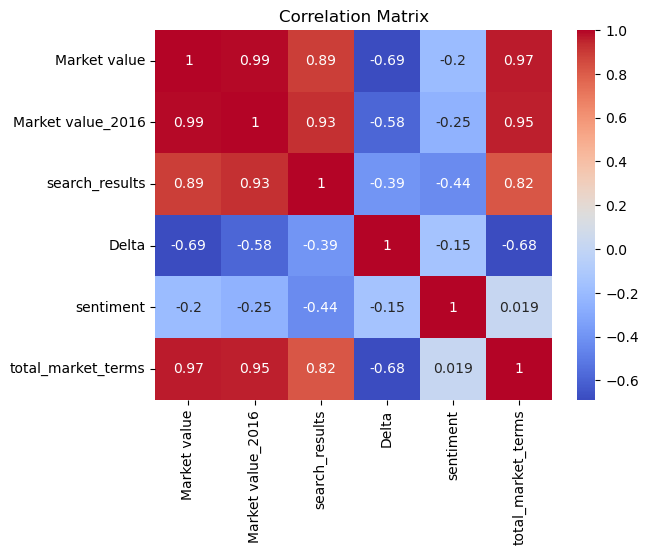

In [136]:
#show correlation matrix between 'Market Value', 'Market value_2016', 'Delta', 'sentiment', 'sentiment_x', 'sentiment_y', total_market_terms', 'total_market_terms_x', 'total_market_terms_y'

correlation_matrix = final_data[['Market value', f'Market value_{next_year}', 'search_results', 'Delta', 'sentiment', 'total_market_terms']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

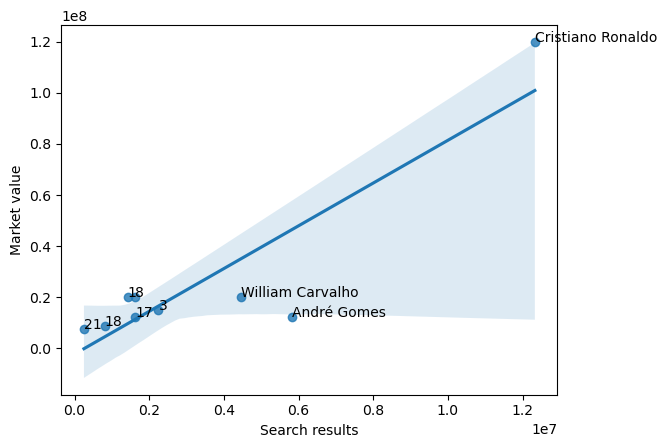

In [ ]:


sns.regplot(data=final_data, x='search_results', y='Market value', fit_reg=True)
plt.xlabel('Search results')
plt.ylabel('Market value')

# add player names and ids
top_players = final_data.nlargest(3, 'search_results')
for i, row in top_players.iterrows():
    plt.text(row['search_results'], row['Market value'], row['Name'])

rest_players = final_data.drop(top_players.index)
for i, row in rest_players.iterrows():
    plt.text(row['search_results'], row['Market value'], row['#'])

plt.show()